## Settings

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import tracemalloc
import random
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score , recall_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Path to the dataset
train_path = './assets/train/'
test_path = './assets/test/'

# Feature extractor (SIFT)
sift = cv2.SIFT_create(contrastThreshold=0.01)

### Create Descriptors

In [2]:
def extract_descriptors_from_image(image_path):
    """
    Extract exactly a specified number of descriptors from an image using SIFT.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found or invalid: {image_path}")
    
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    if descriptors is None or len(descriptors) == 0:
        raise ValueError(f"No descriptors found in image: {image_path}")

    return descriptors

In [3]:
def collect_descriptors_all(data_path):
    """
    Collect descriptors and their corresponding labels.
    """
    all_descriptors = []
    all_labels = []
    
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    
    num_des_tot = 0
    num_des_class_dist = []
    for i, class_name in enumerate(classes):
        class_folder = os.path.join(data_path, class_name)
        # print(f"Processing class: {class_name}")
        
        num_des_class = 0
        for image_name in os.listdir(class_folder):
            if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
                image_path = os.path.join(class_folder, image_name)
                try:
                    # Extract descriptors for this image
                    descriptors = extract_descriptors_from_image(image_path)
                    
                    # Append descriptors and corresponding labels
                    all_descriptors += descriptors.tolist()
                    all_labels += [i]*len(descriptors)
                    num_des_class += len(descriptors)
                except ValueError as e:
                    print(f"Error processing {image_name}: {e}")
        num_des_tot += num_des_class
        num_des_class_dist.append(num_des_class)
    print(f'total number of descriptors: {num_des_tot}')
    print(f'number of descriptors per class: {num_des_class_dist}')
    
    # Convert to NumPy arrays
    all_descriptors = np.array(all_descriptors)
    all_labels = np.array(all_labels)
    
    return all_descriptors, all_labels, num_des_class_dist

In [4]:
def collect_descriptors_with_labels(data_path):
    """
    Collect descriptors and their corresponding labels.
    """
    all_descriptors = []
    all_labels = []
    
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

    num_des_tot = 0
    num_des_class_dist = []
    for i, class_name in enumerate(classes):
        class_folder = os.path.join(data_path, class_name)
        # print(f"Processing class: {class_name}")
        
        for image_name in os.listdir(class_folder):
            if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
                image_path = os.path.join(class_folder, image_name)
                try:
                    # Extract descriptors for this image
                    descriptors = extract_descriptors_from_image(image_path)
                    all_descriptors.append(descriptors.tolist())
                    all_labels.append(i)
                except ValueError as e:
                    print(f"Error processing {image_name}: {e}")
    
    # Convert to NumPy arrays
    all_labels = np.array(all_labels)
    
    return all_descriptors, all_labels

In [5]:
# Extract descriptors and labels
descriptors_pool, labels_pool, num_des_class_dist = collect_descriptors_all(train_path)

if len(descriptors_pool) > 100000:
    descriptors_pool = descriptors_pool[np.random.choice(descriptors_pool.shape[0], 100000, replace=False)]

print(f'number of remained descriptors: {len(descriptors_pool)}')
print("Descriptor extraction completed.")

cls_name = ['tick', 'trilobite', 'umbrella', 'watch', 'water_lilly', 'wheelchair', 'wild_cat', 'windsor_chair', 'wrench', 'yin_yang']

total number of descriptors: 107604
number of descriptors per class: [16979, 12121, 6756, 9669, 12299, 15063, 16334, 6954, 3223, 8206]
number of remained descriptors: 100000
Descriptor extraction completed.


## Q2. RF Classifier

In [6]:
# Construct K-menas codebook
k = 30

start_time = time.perf_counter()

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=k, random_state=42, verbose=0, n_init=10)
kmeans.fit(descriptors_pool)

codebook_cons_time = time.perf_counter() - start_time

print(f'time for codebook construction time: {codebook_cons_time}')

# Access cluster centers and labels
k_means_codebook = kmeans.cluster_centers_  # Shape: (k, 128)
labels = kmeans.labels_  # Shape: (104008,)

time for codebook construction time: 8.521200100076385


In [7]:
def create_bow_histogram(img_descriptors, kmeans):
    # Predict the closest cluster for each descriptor
    labels = kmeans.predict(img_descriptors)  # This gives the cluster index for each descriptor
    
    k = kmeans.n_clusters
    img_bow = np.zeros(k)

    for label in labels:
        img_bow[label] += 1

    # Normalize the histogram to get a normalized BoW representation
    img_bow = img_bow / np.sum(img_bow)  # Normalize to make it a probability distribution

    return img_bow
    # return labels

In [8]:
def vq_process(data_descriptors, kmeans):
    data_bow = []
    for descriptors in data_descriptors:
        image_bow = create_bow_histogram(descriptors, kmeans)
        data_bow.append(image_bow)
    data_bow = np.array(data_bow)

    return data_bow

In [9]:
# Create Train data
train_descriptors, train_labels = collect_descriptors_with_labels(train_path)

start_time = time.perf_counter()
train_bow = vq_process(train_descriptors, kmeans)
vq_time = time.perf_counter() - start_time

print(f'vector quantization time for train data: {vq_time}')

x_train = train_bow
y_train = train_labels

vector quantization time for train data: 0.5738577999873087


In [10]:
# Extract test descriptors and labels
test_descriptors, test_labels = collect_descriptors_with_labels(test_path)

start_time = time.perf_counter()
test_bow = vq_process(test_descriptors, kmeans)
vq_time = time.perf_counter() - start_time

print(f'vector quantization time for test data: {vq_time}')

x_test = test_bow
y_test = test_labels

vector quantization time for test data: 0.5597154999850318


### RF Classifier

In [11]:
def RF_classification(x_train, y_train, x_test, n_estimators=30, max_depth=5, bootstrap=True, random_state=None, max_samples=0.7, max_features=0.7, criterion='entropy'):
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap, random_state=random_state, max_samples=max_samples, max_features=max_features, criterion=criterion)
    # Train ----------------------------------------------------------
    tracemalloc.start() 
    start_time = time.perf_counter()
    
    rf_clf.fit(x_train, y_train.ravel())
    
    train_time = time.perf_counter() - start_time
    current, train_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    y_train_pred = rf_clf.predict(x_train)

    # Test ----------------------------------------------------------
    tracemalloc.start() 
    start_time = time.perf_counter()

    y_test_pred = rf_clf.predict(x_test)

    test_time = time.perf_counter()- start_time
    current, test_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Retrieve the maximum depth of each tree in the forest
    tree_depths = [estimator.tree_.max_depth for estimator in rf_clf.estimators_]
    max_tree_depth = max(tree_depths)

    return y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth

### Change one parameter per experiment

In [12]:
def q2_measurements(parameter_list, change_type, n_iter):
    train_accuracy_list = []
    test_accuracy_list = []

    train_time_list = []
    test_time_list = []

    for parameter in parameter_list:
        avg_train_accuracy, avg_test_accuracy, avg_train_time, avg_test_time = 0, 0, 0, 0

        for i in range(n_iter):
            if change_type == 'estimator':
                y_train_pred, y_test_pred, train_time, test_time, _, _, _ = RF_classification(x_train, y_train, x_test, n_estimators=parameter, max_depth=5, bootstrap=True, random_state=None, max_samples=0.7, max_features=0.7, criterion='entropy')
            elif change_type == 'depth':
                y_train_pred, y_test_pred, train_time, test_time, _, _, _ = RF_classification(x_train, y_train, x_test, n_estimators=30, max_depth=parameter, bootstrap=True, random_state=None, max_samples=0.7, max_features=0.7, criterion='entropy')
            elif change_type == 'randomness':
                y_train_pred, y_test_pred, train_time, test_time, _, _, _ = RF_classification(x_train, y_train, x_test, n_estimators=30, max_depth=5, bootstrap=True, random_state=None, max_samples=parameter, max_features=parameter, criterion='entropy')
            avg_train_accuracy += accuracy_score(y_train.T, y_train_pred)
            avg_test_accuracy += accuracy_score(y_test.T, y_test_pred)
            avg_train_time += train_time
            avg_test_time += test_time
        
        train_accuracy_list.append(avg_train_accuracy/n_iter)
        test_accuracy_list.append(avg_test_accuracy/n_iter)
        train_time_list.append(avg_train_time/n_iter)
        test_time_list.append(avg_test_time/n_iter)
    
    return train_accuracy_list, test_accuracy_list, train_time_list, test_time_list        


In [13]:
def draw_accuracy_graph(parameter_list, change_type, train_accuracy_list, test_accuracy_list):
    plt.plot(parameter_list, train_accuracy_list, label='Train Accuracy', marker='s', linestyle='-', color='r')
    plt.plot(parameter_list, test_accuracy_list, label='Test Accuracy', marker='s', linestyle='-', color='b')
    plt.xticks(parameter_list)
    if change_type == 'estimator':
        plt.xlabel('Number of estimators', fontsize=20)
    elif change_type == 'depth':
        plt.xlabel('Maximum depth', fontsize=20)
    elif change_type == 'randomness':
        plt.xlabel('Randomness (ratio)', fontsize=20)
    plt.ylabel('Accuracy', fontsize=20)
    # plt.title('Accuracy over number of estimators')
    plt.legend(fontsize=15)
    plt.grid(True)

In [17]:
def draw_time_graph(parameter_list, change_type, train_time_list, test_time_list):
    plt.plot(parameter_list, train_time_list, label='Train Time', marker='s', linestyle='-', color='r')
    plt.plot(parameter_list, test_time_list, label='Test Time', marker='s', linestyle='-', color='b')
    plt.xticks(parameter_list)
    if change_type == 'estimator':
        plt.xlabel('Number of estimators', fontsize=20)
    elif change_type == 'depth':
        plt.xlabel('Maximum depth', fontsize=20)
    elif change_type == 'randomness':
        plt.xlabel('Randomness (ratio)', fontsize=20)
    plt.ylabel('Runtime (second)', fontsize=20)
    
    plt.legend(fontsize=15)
    plt.grid(True)

In [15]:
n_estimators_list = [i*30 for i in range(1,11)]
max_depth_list = [i for i in range(3, 15)]
randomness_parameter = [0.1 * i for i in range(3,11)]

In [16]:
# change number of estimators
train_accuracy_list, test_accuracy_list, train_time_list, test_time_list = q2_measurements(n_estimators_list, 'estimator', 10)

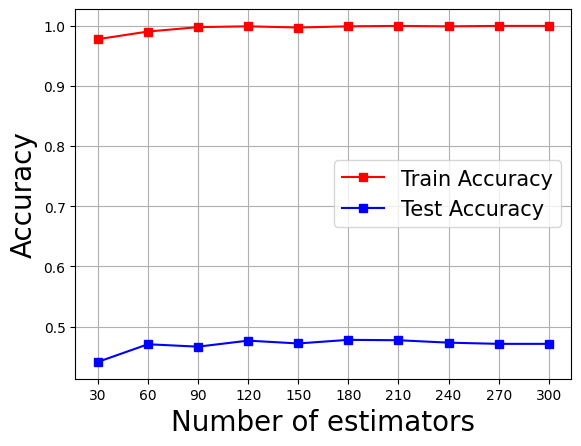

In [17]:
draw_accuracy_graph(n_estimators_list, 'estimator', train_accuracy_list, test_accuracy_list)

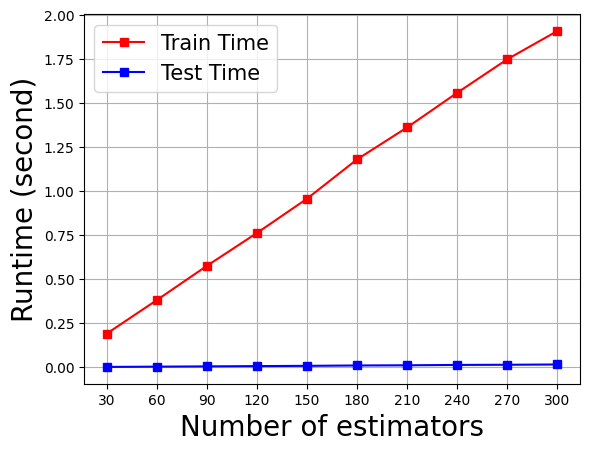

In [18]:
draw_time_graph(n_estimators_list, 'estimator', train_time_list, test_time_list)

In [22]:
# change maximum depth
train_accuracy_list, test_accuracy_list, train_time_list, test_time_list = q2_measurements(max_depth_list, 'depth', 10)

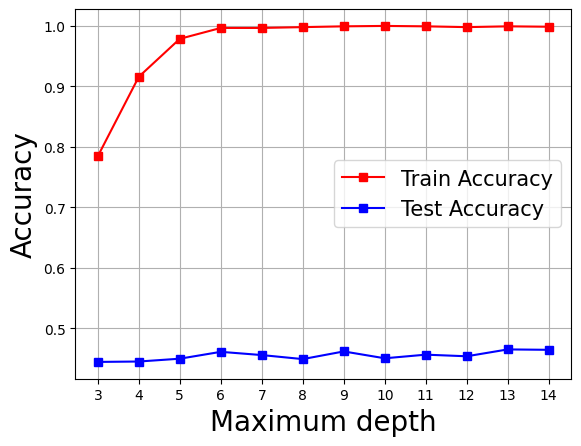

In [23]:
draw_accuracy_graph(max_depth_list, 'depth', train_accuracy_list, test_accuracy_list)

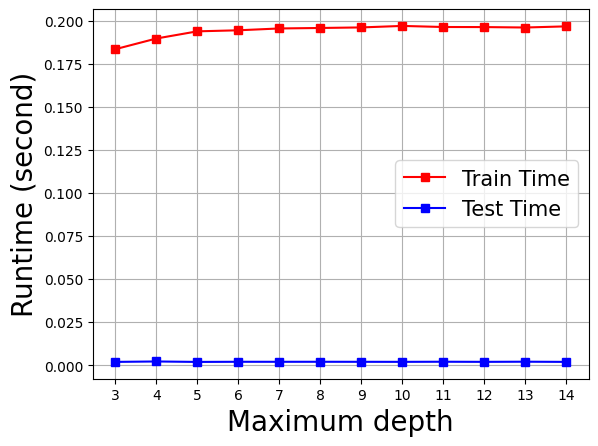

In [24]:
draw_time_graph(max_depth_list, 'depth', train_time_list, test_time_list)

In [28]:
# change randomness
train_accuracy_list, test_accuracy_list, train_time_list, test_time_list = q2_measurements(randomness_parameter, 'randomness', 10)

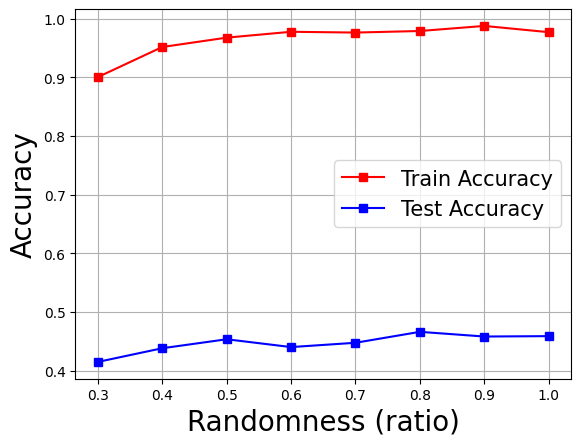

In [29]:
draw_accuracy_graph(randomness_parameter, 'randomness', train_accuracy_list, test_accuracy_list)

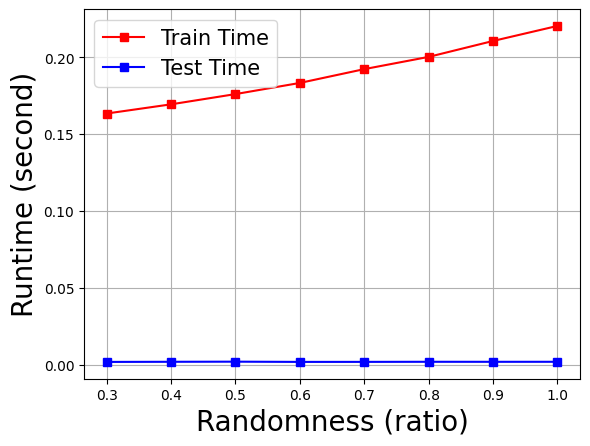

In [30]:
draw_time_graph(randomness_parameter, 'randomness', train_time_list, test_time_list)

In [31]:
# Best settings
best_estimators = 180
best_depth = 11
best_randomness = 0.8

### Axis aligned test

In [17]:
n_iter = 10
avg_train_accuracy, avg_test_accuracy, avg_train_time, avg_test_time = 0,0,0,0

for i in range(10):
    y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train, y_train, x_test, n_estimators=best_estimators, max_depth=best_depth, bootstrap=True, random_state=None, max_samples=best_randomness, max_features=best_randomness, criterion='entropy')
    avg_train_accuracy += accuracy_score(y_train.T, y_train_pred)
    avg_test_accuracy += accuracy_score(y_test.T, y_test_pred)
    avg_train_time += train_time
    avg_test_time += test_time

print(f'average train time: {avg_train_time/n_iter}')
print(f'avegrage train accuracy: {avg_train_accuracy/n_iter}')
print('\n')

print(f'average test time: {avg_test_time/n_iter}')
print(f'average test_accuracy: {avg_test_accuracy/n_iter}')
print('\n')

average train time: 1.214233939978294
avegrage train accuracy: 1.0


average test time: 0.009073929989244788
average test_accuracy: 0.5153333333333332




### Two-pixel test

In [18]:
def create_two_pixel_features(x_train, x_test, n_pairs=None, random_seed=None):
    x_combined = np.concatenate([x_train, x_test], axis=1)

    n_features, n_samples = x_combined.shape

    # Set random seed if provided
    if random_seed is not None:
        random.seed(random_seed)

    # Generate all unique pairs of features where i != j
    feature_pairs = [(i, j) for i in range(n_features) for j in range(i + 1, n_features)]

    # If n_pairs is specified, randomly select a subset of feature pairs
    if n_pairs is not None and n_pairs < len(feature_pairs):
        feature_pairs = random.sample(feature_pairs, n_pairs)
    
    # Initialize a new features matrix for pairwise differences
    new_features = np.zeros((len(feature_pairs), n_samples))

    # Fill in the new features with pairwise differences
    for idx, (i, j) in enumerate(feature_pairs):
        new_features[idx, :] = x_combined[i, :] - x_combined[j, :]

    x_train_2pix = new_features[:, :x_train.shape[1]]
    x_test_2pix = new_features[:, x_train.shape[1]:]

    return x_train_2pix.T, x_test_2pix.T

In [87]:
n_pairs = x_train.shape[1]

start_time = time.perf_counter()
x_train_2pix, x_test_2pix = create_two_pixel_features(x_train.T, x_test.T, n_pairs=n_pairs, random_seed=0)
tp_const_time = time.perf_counter() - start_time

n_iter = 10
avg_train_accuracy, avg_test_accuracy, avg_train_time, avg_test_time = 0,0,0,0

for i in range(n_iter):
    y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train_2pix, y_train, x_test_2pix, n_estimators=best_estimators, max_depth=best_depth, bootstrap=True, random_state=None, max_samples=best_randomness, max_features=best_randomness, criterion='entropy')
    avg_train_accuracy += accuracy_score(y_train.T, y_train_pred)
    avg_test_accuracy += accuracy_score(y_test.T, y_test_pred)
    avg_train_time += train_time
    avg_test_time += test_time

print(f'average train time: {tp_const_time + avg_train_time/n_iter}')
print(f'avegrage train accuracy: {avg_train_accuracy/n_iter}')
print('\n')

print(f'average test time: {tp_const_time + avg_test_time/n_iter}')
print(f'average test_accuracy: {avg_test_accuracy/n_iter}')
print('\n')

average train time: 1.2300115599646233
avegrage train accuracy: 1.0


average test time: 0.009757249953690917
average test_accuracy: 0.454




### Impcact of vocabulary size on classification accuracy

In [57]:
# Number of clusters (k)
def Kmeans_const_times(k_list, num_iter):
    const_time = []
    avg_time = 0
    codebooks = []

    for k in k_list:
        n_codebooks = []
        for i in range(num_iter):
            start_time = time.perf_counter()
            # Initialize and fit KMeans
            kmeans = KMeans(n_clusters=k, random_state=42, verbose=0, n_init=10)
            kmeans.fit(descriptors_pool)
            
            codebook_cons_time = time.perf_counter() - start_time
            avg_time += codebook_cons_time

            n_codebooks.append(kmeans)

        const_time.append(avg_time/(num_iter*len(k_list)))
        codebooks.append(n_codebooks)
    
    return const_time, codebooks

In [33]:
def avg_accuracy(train_descriptors, test_descriptors, n_iter, codebooks, codebook_num):
    test_accuracy_list = []
    for n_codebook in codebooks:
        codebook = n_codebook[codebook_num]
        test_accuracy = 0
        for i in range(n_iter):
            x_train = vq_process(train_descriptors, codebook)
            y_train = train_labels

            x_test = vq_process(test_descriptors, codebook)
            y_test = test_labels

            y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train, y_train, x_test, n_estimators=180, max_depth=11, bootstrap=True, random_state=None, max_samples=0.8, max_features=0.8, criterion='entropy')
            test_accuracy += accuracy_score(y_test.T, y_test_pred)
        
        test_accuracy_list.append(test_accuracy/(n_iter))

    return test_accuracy_list

In [34]:
k_list = [i*32 for i in range(1,10)]
num_iter = 3

const_time, codebooks = Kmeans_const_times(k_list, num_iter)

In [35]:
train_descriptors, train_labels = collect_descriptors_with_labels(train_path)
test_descriptors, test_labels = collect_descriptors_with_labels(test_path)
n_iter = 10

codebook_num = 0
test_accuracy_list_1 = avg_accuracy(train_descriptors, test_descriptors, n_iter, codebooks, codebook_num)

codebook_num = 1
test_accuracy_list_2 = avg_accuracy(train_descriptors, test_descriptors, n_iter, codebooks, codebook_num)

codebook_num = 2
test_accuracy_list_3 =avg_accuracy(train_descriptors, test_descriptors, n_iter, codebooks, codebook_num)

KeyboardInterrupt: 

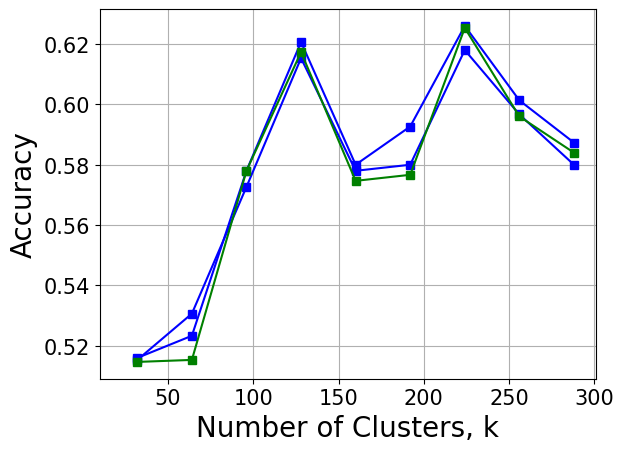

In [ ]:
# Plot accuracy on the first subplot
plt.plot(k_list, test_accuracy_list_1, label='1st codebook', marker='s', linestyle='-', color='b')
plt.plot(k_list, test_accuracy_list_2, label='2nd codebook', marker='s', linestyle='-', color='b')
plt.plot(k_list, test_accuracy_list_3, label='3th codebook', marker='s', linestyle='-', color='g')
# plt.plot(k_list, test_accuracy_list_3, marker='s', linestyle='-', color='b')
plt.xlim(left=10)
plt.xlabel('Number of Clusters, k', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
# plt.title('Accuracy over number of estimators')
# plt.legend(fontsize=15)
plt.grid(True)

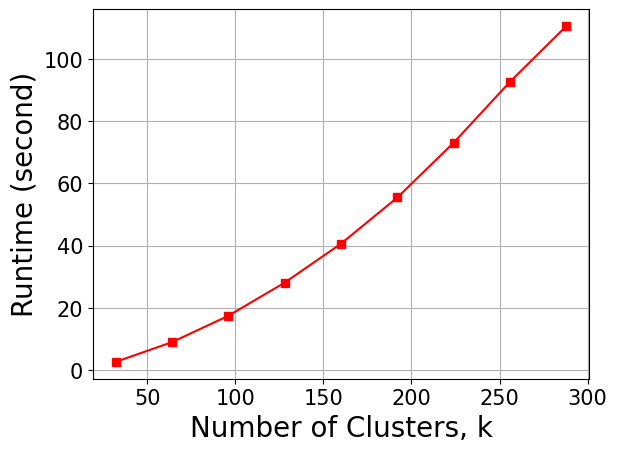

In [56]:
# Plot accuracy on the first subplot
plt.plot(k_list, const_time, label='codebook constructio ntime', marker='s', linestyle='-', color='r')
# plt.xlim(left=10)
plt.xlabel('Number of Clusters, k', fontsize=20)
plt.ylabel('Runtime (second)', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
# plt.title('Accuracy over number of estimators')
# plt.legend(fontsize=15)
plt.grid(True)

In [58]:
const_time

array([  2.548782  ,   8.89768476,  17.3841378 ,  28.0607884 ,
        40.59742532,  55.4671402 ,  73.12054278,  92.73077332,
       110.66663548])

In [42]:
n_iter = 10
avg_vq_time_list = []

for idx in range(len(k_list)):
    avg_vq_time = 0
    for i in range(n_iter):
        start_time = time.perf_counter()
        train_bow = vq_process(train_descriptors, codebooks[idx][1])
        avg_vq_time += time.perf_counter() - start_time
    avg_vq_time_list.append(avg_vq_time/n_iter)

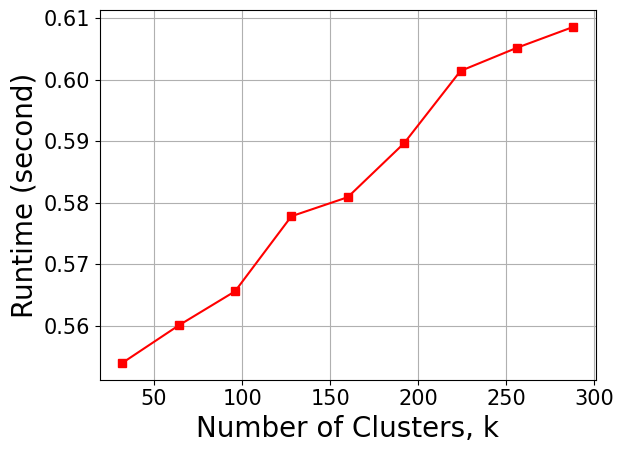

In [43]:
# Plot accuracy on the first subplot
plt.plot(k_list, avg_vq_time_list, label='vector quantization time', marker='s', linestyle='-', color='r')
# plt.xlim(left=10)
plt.xlabel('Number of Clusters, k', fontsize=20)
plt.ylabel('Runtime (second)', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
# plt.title('Accuracy over number of estimators')
# plt.legend(fontsize=15)
plt.grid(True)

In [44]:
avg_vq_time_list

[0.5540113199967891,
 0.5600974699947983,
 0.5656353599973954,
 0.5778180500026793,
 0.5809139300021343,
 0.5896790600148961,
 0.6014033900224603,
 0.6051591399940662,
 0.6085484100156464]

### Best Settings

In [59]:
# Construct K-menas codebook
k = 150

start_time = time.perf_counter()

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=k, random_state=42, verbose=0, n_init=10)
kmeans.fit(descriptors_pool)

codebook_cons_time = time.perf_counter() - start_time

print(f'time for codebook construction time: {codebook_cons_time}')

# Access cluster centers and labels
k_means_codebook = kmeans.cluster_centers_  # Shape: (k, 128)
labels = kmeans.labels_  # Shape: (104008,)

time for codebook construction time: 34.91155359998811


In [61]:
# Create Train data
train_descriptors, train_labels = collect_descriptors_with_labels(train_path)

start_time = time.perf_counter()
train_bow = vq_process(train_descriptors, kmeans)
vq_time = time.perf_counter() - start_time

print(f'vector quantization time for train data: {vq_time}')

x_train = train_bow
y_train = train_labels

# Extract test descriptors and labels
test_descriptors, test_labels = collect_descriptors_with_labels(test_path)

start_time = time.perf_counter()
test_bow = vq_process(test_descriptors, kmeans)
vq_time = time.perf_counter() - start_time

print(f'vector quantization time for test data: {vq_time}')

x_test = test_bow
y_test = test_labels

vector quantization time for train data: 0.6056687999516726
vector quantization time for test data: 0.6168649999890476


In [65]:
# best settings
avg_accuracy = 0
n_iter = 10

for i in range(n_iter):
    y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train, y_train, x_test, n_estimators=180, max_depth=11, bootstrap=True, random_state=None, max_samples=0.8, max_features=0.8, criterion='entropy')
    avg_accuracy += accuracy_score(y_test.T, y_test_pred)
print(avg_accuracy/n_iter)

0.6173333333333334


In [66]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test.T, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    # plt.title("Confusion Matrix")
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tight_layout()
    plt.show()

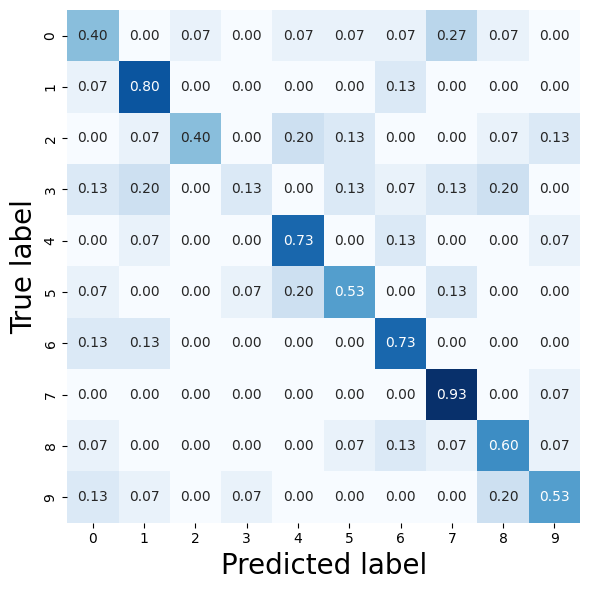

In [67]:
plot_confusion_matrix(y_test, y_test_pred)

In [ ]:
def suc_fail_idx(y_test, y_pred):
    success_idx = []
    failure_idx = []

    for i in range(len(y_pred)):
        if y_test.T[i] == y_pred[i]:
            success_idx.append(i)
        else:
            failure_idx.append(i)

    return success_idx, failure_idx

success_idx, failure_idx = suc_fail_idx(y_test, y_test_pred)

In [ ]:
for idx in success_idx:
    if idx >= 60 and idx <75:
        print(idx)
        break

for idx in failure_idx:
    if idx >= 45 and idx < 60:
        print(idx)
        break

60
45
